In [2]:
!pip install keras-swa==0.1.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-swa: filename=keras_swa-0.1.5-py3-none-any.whl size=9705 sha256=6666c0e506811eaa7ce923218a75fe49ae279be0bffea35ffea35135c57c83ac
  Stored in directory: /root/.cache/pip/wheels/13/35/d3/72e8eefff7c30313a87aa5d513ac40f0c288aa9835951c8b19
Successfully built keras-swa


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 26 13:55:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from swa.tfkeras import SWA
import tensorflow.keras.backend as K

In [5]:
from keras.datasets import cifar10

In [ ]:
(trainX, trainy), (testX, testy) = cifar10.load_data()
trainX = trainX/255
testX = testX/255

170498071/170498071 [==============================] - 4s 0us/step


In [6]:
import numpy as np
import random
import cv2
import os
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K

In [ ]:
lb = LabelBinarizer()                                  #Binarize labels in a one-vs-all fashion.
trainy = lb.fit_transform(trainy)                     #Fit label binarizer and transform multi-class labels to binary labels
testy = lb.fit_transform(testy)

In [ ]:
def label_dict(img, labels):  # creating dictionary of labels
  lab_lis = {}
  for i in range(10):
    lab_lis[i] = []          #declaring key values as labels  in dictionary
  data = list(zip(img, labels))  # list of tuples of each image and label pair
  for im, lab in data:
    idx = np.argmax(lab)
    lab_lis[idx].append((im, lab))
  return lab_lis

In [ ]:
#テストデータラベル
def label_dict_test(img, labels):
    lab_lis = {}
    for i in range(10):
        lab_lis[i] = []
    data = list(zip(img, labels))
    for im, lab in data:
        idx = np.argmax(lab)
        lab_lis[idx].append((im, lab))
    return lab_lis


In [ ]:
# トレーニングデータ分類
t = label_dict(trainX, trainy)
# テストデータ分類
t_test = label_dict_test(testX, testy)

In [ ]:
unlab_data = []
unlab_img_data = []
unlab_img_lab = []
for i in range(len(t)):
  unlab_data.extend(t[i][4000:]) # extracting 1000 imgaes from each class in the training set to generate the pool of so called unlabeled set
for x,y in unlab_data:
  unlab_img_data.append(x)
  unlab_img_lab.append(y)

In [ ]:
client_names = ["client_"+str(i) for i in range(10)]
total_data_per_client = 4000  # 各クライアントあたりの最大データ数
primary_data = int((19/20) * total_data_per_client)  # クラス0,1データ比率によるデータ数
secondary_data = total_data_per_client - primary_data  # 残りのクラスに割り当てるデータ数

# クライアント データの初期化と比率に応じて再分配
client_data = {client: [] for client in client_names}
for i in range(10):
    primary_class = i % 10  # 主要クラス選択
    secondary_class = (i + 1) % 10  # 2番目の主要クラス選択

    # 主要クラスのデータ割り当て
    client_data[client_names[i]].extend(t[primary_class][:int(primary_data/2)])
    client_data[client_names[i]].extend(t[secondary_class][:int(primary_data/2)])

    # 残りのクラスデータ割り当て
    k = 0
    per_secondary_class_data = int(secondary_data / 8)  # 残りのクラスに割り当てるデータ数（クラス2~9）
    for j in range(10):
        if j != primary_class and j != secondary_class:
            client_data["client_"+str(i)].extend(t[j][per_secondary_class_data * k : per_secondary_class_data * (k+1)])  # add secondary class data
            k += 1

# クライアント別に割り当てられたトレインデータの個数出力（クラス別）
for client in client_names:
    class_count = {str(c): 0 for c in range(10)}  # クラス別データ数の初期化
    for data in client_data[client]:
        class_label = np.argmax(data[1])  # データからクラスラベルを抽出
        class_count[str(class_label)] += 1  # 当該クラスのデータ数の増加

    # 出力
    class_count_str = ", ".join([f"class{k}: {v}個" for k, v in class_count.items()])
    print(f"{client} has {class_count_str}")


client_0 has class0: 1900個, class1: 1900個, class2: 25個, class3: 25個, class4: 25個, class5: 25個, class6: 25個, class7: 25個, class8: 25個, class9: 25個
client_1 has class0: 25個, class1: 1900個, class2: 1900個, class3: 25個, class4: 25個, class5: 25個, class6: 25個, class7: 25個, class8: 25個, class9: 25個
client_2 has class0: 25個, class1: 25個, class2: 1900個, class3: 1900個, class4: 25個, class5: 25個, class6: 25個, class7: 25個, class8: 25個, class9: 25個
client_3 has class0: 25個, class1: 25個, class2: 25個, class3: 1900個, class4: 1900個, class5: 25個, class6: 25個, class7: 25個, class8: 25個, class9: 25個
client_4 has class0: 25個, class1: 25個, class2: 25個, class3: 25個, class4: 1900個, class5: 1900個, class6: 25個, class7: 25個, class8: 25個, class9: 25個
client_5 has class0: 25個, class1: 25個, class2: 25個, class3: 25個, class4: 25個, class5: 1900個, class6: 1900個, class7: 25個, class8: 25個, class9: 25個
client_6 has class0: 25個, class1: 25個, class2: 25個, class3: 25個, class4: 25個, class5: 25個, class6: 1900個, class7: 1900個, cla

In [ ]:
client_test_data = {f"client_{i}": [] for i in range(10)}

for i in range(10):
    client_name = f"client_{i}"
    client_test_data[client_name] = []

    # 主要クラスデータを比率で計算して割り当て
    primary_class_1 = i % 10
    primary_class_2 = (i + 1) % 10

    # 総データ個数を1000個に設定
    total_test_data = 1000  # 各クライアントごとの総データ個数を1000個に設定
    primary_data = int(total_test_data * 19 / 20)  # 19:1の割合で主要クラスデータ
    secondary_data = total_test_data - primary_data  # 残りのデータ

    # 主要クラスのデータ割り当て
    primary_class_1_data = primary_data // 2
    primary_class_2_data = primary_data - primary_class_1_data

    # 各クラスで割り当てるデータ数が十分であることを確認し、割り当て
    client_test_data[client_name].extend(t_test[primary_class_1][:primary_class_1_data])
    client_test_data[client_name].extend(t_test[primary_class_2][:primary_class_2_data])

    # 残りのクラスデータ割り当て
    k = 0
    per_secondary_class_data = secondary_data // 8  # 残りのクラスに割り当てるデータ数（クラス2~9）
    for j in range(10):
        if j != primary_class_1 and j != primary_class_2:
            allocation = per_secondary_class_data if k < 7 else secondary_data - per_secondary_class_data * 7
            client_test_data[client_name].extend(t_test[j][:allocation])
            k += 1

for client in client_names:
    total_test_data_count = len(client_test_data[client])
    class_count = {str(c): 0 for c in range(10)}  # クラス別データ数の初期化

    for data in client_test_data[client]:
        class_label = np.argmax(data[1])  # データからクラスラベルを抽出
        class_count[str(class_label)] += 1  # 当該クラスのデータ数の増加

    print(f"Client {client} has a total of {total_test_data_count} test data.")
    class_count_str = ", ".join([f"class{k}: {v}個" for k, v in class_count.items()])
    print(f"Class distribution: {class_count_str}")

Client client_0 has a total of 1000 test data.
Class distribution: class0: 475個, class1: 475個, class2: 6個, class3: 6個, class4: 6個, class5: 6個, class6: 6個, class7: 6個, class8: 6個, class9: 8個
Client client_1 has a total of 1000 test data.
Class distribution: class0: 6個, class1: 475個, class2: 475個, class3: 6個, class4: 6個, class5: 6個, class6: 6個, class7: 6個, class8: 6個, class9: 8個
Client client_2 has a total of 1000 test data.
Class distribution: class0: 6個, class1: 6個, class2: 475個, class3: 475個, class4: 6個, class5: 6個, class6: 6個, class7: 6個, class8: 6個, class9: 8個
Client client_3 has a total of 1000 test data.
Class distribution: class0: 6個, class1: 6個, class2: 6個, class3: 475個, class4: 475個, class5: 6個, class6: 6個, class7: 6個, class8: 6個, class9: 8個
Client client_4 has a total of 1000 test data.
Class distribution: class0: 6個, class1: 6個, class2: 6個, class3: 6個, class4: 475個, class5: 475個, class6: 6個, class7: 6個, class8: 6個, class9: 8個
Client client_5 has a total of 1000 test data.
Cla

In [ ]:
def batch(zip_data, batch_size = 40):
  data, label = zip(*zip_data)  # Unzipping the img and label pair
  dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label))) # create a dataset object to make use of other transformation attributes
  return dataset.shuffle(len(label)).batch(batch_size)# shuffles data and creates batches of size 40

In [ ]:
client_batched = {}
for (client_name, data) in client_data.items():
  client_batched[client_name] = batch(data)

test_batched = tf.data.Dataset.from_tensor_slices((testX, testy)).batch(len(testy))
unlab_dataset = tf.data.Dataset.from_tensor_slices((unlab_img_data)).batch(len(unlab_img_data))

In [ ]:
class MLP:
    @staticmethod
    def build():
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))) # 32 filters of size 3*3
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(AveragePooling2D((2, 2))) # aveeraging the cell cvales for size of 2*2, witha stride of 2
        model.add(Dropout(0.2))  # randomly assign the value o to nodes, with probability of 0.2
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(AveragePooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(AveragePooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(10, activation='softmax'))
        return model

In [ ]:
model = MLP()
model = model.build()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 average_pooling2d (Average  (None, 16, 16, 32)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [ ]:
t = model.get_weights()
for v in t:
  print(np.shape(v))

(3, 3, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(2048, 128)
(128,)
(128, 10)
(10,)


In [ ]:
comms_round = 40
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=0.01,
                momentum=0.9
               )
optimizer2 = SGD(learning_rate=0.001,
                 momentum=0.9
               )

In [ ]:
weight_scale = []
for (name, data) in client_data.items():
  weight_scale.append(len(data)/40000)
weight_scale = np.array(weight_scale).reshape((len(weight_scale),1))

In [ ]:
def sum_scaled_weights(scaled_weight_list, M, unlab_data):
    avg_grad_mean = list()
    avg_grad_var = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        if len(np.shape(grad_list_tuple)) == 5:
          w = weight_scale.reshape((len(weight_scale), 1, 1, 1, 1))
        elif len(np.shape(grad_list_tuple)) == 4:
          w = weight_scale.reshape((len(weight_scale), 1, 1, 1))
        elif len(np.shape(grad_list_tuple)) == 3:
          w = weight_scale.reshape((len(weight_scale), 1, 1))
        else:
          w = weight_scale
        layer_mean = np.sum(grad_list_tuple*w, axis=0)
        layer_variance = np.sum(np.power(grad_list_tuple - layer_mean, 2)*w, axis = 0)
        avg_grad_mean.append(layer_mean)
        avg_grad_var.append(layer_variance)
    return avg_grad_mean


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
def evaluate_model_on_clients(model, client_test_data, client_names):
    results = {}
    for client_name in client_names:
        test_data, test_labels = zip(*client_test_data[client_name])
        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)

        # 結果をディクショナリーに保存
        results[client_name] = {'accuracy': test_acc, 'loss': test_loss}
    return results


In [ ]:
all_clients_results = {}

for train_client in client_names:
    # モデルの初期化とコンパイル
    mlp_local = MLP()
    local_model = mlp_local.build()

    new_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9)
    local_model.compile(loss=loss, optimizer=new_optimizer, metrics=metrics)

    # クライアントデータでモデルトレーニング
    train_data, train_labels = zip(*client_data[train_client])
    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    local_model.fit(train_data, train_labels, epochs=20, verbose=0)

    # 他のクライアントのテストデータのモデル評価
    test_results = evaluate_model_on_clients(local_model, client_test_data, client_names)
    all_clients_results[train_client] = test_results

    # 訓練されたクライアントモデルの評価結果出力
    print(f"Results for model trained on {train_client}:")
    for client, results in test_results.items():
        print(f"  Test on {client} - Accuracy: {results['accuracy']:.4f}, Loss: {results['loss']:.4f}")

    K.clear_session()




Results for model trained on client_0:
  Test on client_0 - Accuracy: 0.8940, Loss: 0.3845
  Test on client_1 - Accuracy: 0.5040, Loss: 2.1138
  Test on client_2 - Accuracy: 0.0440, Loss: 4.3444
  Test on client_3 - Accuracy: 0.0370, Loss: 4.1052
  Test on client_4 - Accuracy: 0.0630, Loss: 3.6683
  Test on client_5 - Accuracy: 0.1300, Loss: 3.6199
  Test on client_6 - Accuracy: 0.1370, Loss: 3.4303
  Test on client_7 - Accuracy: 0.0470, Loss: 4.4507
  Test on client_8 - Accuracy: 0.0140, Loss: 5.4989
  Test on client_9 - Accuracy: 0.4330, Loss: 3.0379
Results for model trained on client_1:
  Test on client_0 - Accuracy: 0.4660, Loss: 2.4411
  Test on client_1 - Accuracy: 0.9140, Loss: 0.3612
  Test on client_2 - Accuracy: 0.4690, Loss: 2.3532
  Test on client_3 - Accuracy: 0.0120, Loss: 4.7829
  Test on client_4 - Accuracy: 0.0140, Loss: 4.5911
  Test on client_5 - Accuracy: 0.0140, Loss: 3.7698
  Test on client_6 - Accuracy: 0.0120, Loss: 3.8024
  Test on client_7 - Accuracy: 0.0530,

In [ ]:
# モデル平均出してM_10という新しいモデル

client_models = {}
for client in client_names:
    print(f"Training model for {client}...")
    model = MLP.build()
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])
    train_data, train_labels = zip(*client_data[client])

    # モデル学習とヒストリー保存
    history = model.fit(np.array(train_data), np.array(train_labels), epochs=20, verbose=0)

    # 最後のエポックの精度と損失抽出
    final_epoch_accuracy = history.history['accuracy'][-1]
    final_epoch_loss = history.history['loss'][-1]

    print(f"Train on {client} - Accuracy: {final_epoch_accuracy:.4f}, Loss: {final_epoch_loss:.4f}")

    client_models[client] = model.get_weights()


avg_weights = []
for layer in zip(*[client_models[client] for client in client_names]):
    layer_mean = np.mean(np.array([np.array(w) for w in layer]), axis=0)
    avg_weights.append(layer_mean)

model_M_10 = MLP.build()
model_M_10.set_weights(avg_weights)

# モデルM_10をコンパイル
model_M_10.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])

# 各クライアントのテストデータからモデルM_10を追加学習
for client in client_names:
    print(f"Further training model M_10 with test data of {client}...")
    test_data, test_labels = zip(*client_test_data[client])

    history = model_M_10.fit(np.array(test_data), np.array(test_labels), epochs=20, verbose=0)

    final_epoch_accuracy = history.history['accuracy'][-1]
    final_epoch_loss = history.history['loss'][-1]

    print(f"Test on {client} - Accuracy: {final_epoch_accuracy:.4f}, Loss: {final_epoch_loss:.4f}")

Training model for client_0...
Train on client_0 - Accuracy: 0.9220, Loss: 0.2397
Training model for client_1...
Train on client_1 - Accuracy: 0.9160, Loss: 0.3064
Training model for client_2...
Train on client_2 - Accuracy: 0.7903, Loss: 0.5826
Training model for client_3...
Train on client_3 - Accuracy: 0.8260, Loss: 0.5092
Training model for client_4...
Train on client_4 - Accuracy: 0.8260, Loss: 0.5026
Training model for client_5...
Train on client_5 - Accuracy: 0.8802, Loss: 0.3633
Training model for client_6...
Train on client_6 - Accuracy: 0.9155, Loss: 0.2919
Training model for client_7...
Train on client_7 - Accuracy: 0.9335, Loss: 0.2453
Training model for client_8...
Train on client_8 - Accuracy: 0.9268, Loss: 0.2323
Training model for client_9...
Train on client_9 - Accuracy: 0.8965, Loss: 0.3124
Further training model M_10 with test data of client_0...
Test on client_0 - Accuracy: 0.4930, Loss: 0.9652
Further training model M_10 with test data of client_1...
Test on client

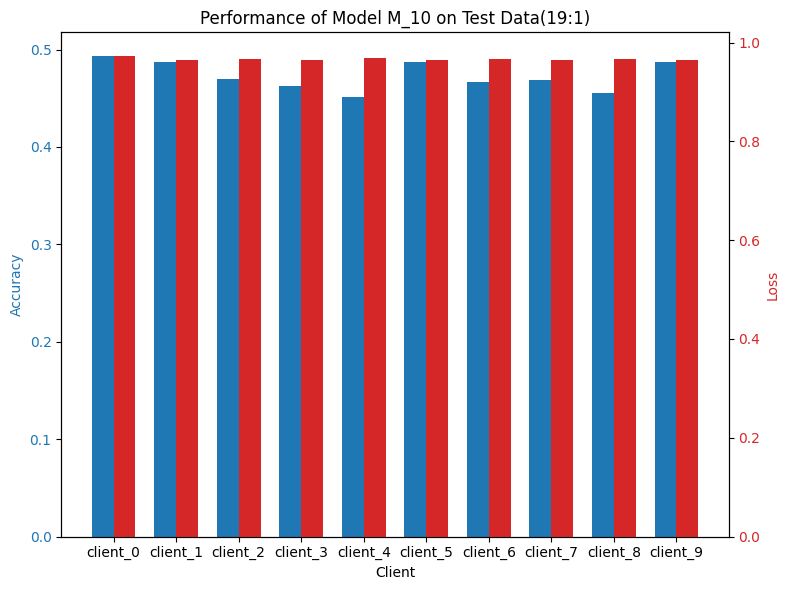

In [ ]:
client_names = [f"client_{i}" for i in range(10)]
test_accuracies = [
    0.4930, 0.4870, 0.4700, 0.4630, 0.4510, 0.4870, 0.4670, 0.4690, 0.4550, 0.4870
]
test_losses = [
    0.9720, 0.9656, 0.9675, 0.9655, 0.9679, 0.9642, 0.9668, 0.9656, 0.9663, 0.9643
]

x = np.arange(len(client_names))

width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 6))

rects1 = ax1.bar(x - width/2, test_accuracies, width, label='Accuracy', color='tab:blue')
ax1.set_xlabel('Client')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(client_names)

ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, test_losses, width, label='Loss', color='tab:red')
ax2.set_ylabel('Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Performance of Model M_10 on Test Data(19:1)')

fig.tight_layout()
plt.show()

In [ ]:
# M_10モデル初期化
model_M_10 = MLP.build()
model_M_10.set_weights(avg_weights)

# 各通信ラウンド実行
for comm_round in range(comms_round):
    print(f"---- Round {comm_round} ----")
    # ローカルモデル重み付けリストの初期化
    scaled_local_weight_list = list()

    # クライアント名を並べ替える
    sorted_client_names = sorted(client_names)

    # 各クライアントのトレーニングデータセットでグローバルモデル学習
    for client in sorted_client_names:
        train_data, train_labels = zip(*client_data[client])
        train_data = np.array(train_data)
        train_labels = np.array(train_labels)

        # M_10モデルで訓練データ学習
        model_M_10.compile(loss=loss,
                           optimizer=SGD(learning_rate=0.01, momentum=0.9),
                           metrics=metrics)
        model_M_10.fit(train_data, train_labels, epochs=20, verbose=0)
        scaled_local_weight_list.append(model_M_10.get_weights())

    # ローカルモデルの重み付けを平均化してグローバルモデルを更新
    new_global_weights = sum_scaled_weights(scaled_local_weight_list, 10, unlab_dataset)
    model_M_10.set_weights(new_global_weights)

    # 各クライアントのテストデータセットでグローバルモデル評価
    for client in sorted_client_names:
        test_data, test_labels = zip(*client_test_data[client])
        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        # M_10 モデルでテストデータ評価
        test_loss, test_acc = model_M_10.evaluate(test_data, test_labels, verbose=0)
        print(f"Client {client} - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
    print("---- End of Round ----\n")


---- Round 0 ----
Client client_0 - Accuracy: 0.0060, Loss: 2.4419
Client client_1 - Accuracy: 0.0060, Loss: 2.4314
Client client_2 - Accuracy: 0.0060, Loss: 2.3728
Client client_3 - Accuracy: 0.0060, Loss: 2.3229
Client client_4 - Accuracy: 0.0060, Loss: 2.2577
Client client_5 - Accuracy: 0.4750, Loss: 2.2093
Client client_6 - Accuracy: 0.4750, Loss: 2.1927
Client client_7 - Accuracy: 0.0060, Loss: 2.2310
Client client_8 - Accuracy: 0.0060, Loss: 2.2708
Client client_9 - Accuracy: 0.0060, Loss: 2.3413
---- End of Round ----

---- Round 1 ----
Client client_0 - Accuracy: 0.5860, Loss: 1.3505
Client client_1 - Accuracy: 0.4690, Loss: 1.5849
Client client_2 - Accuracy: 0.1690, Loss: 2.0754
Client client_3 - Accuracy: 0.2770, Loss: 1.7121
Client client_4 - Accuracy: 0.3520, Loss: 1.6656
Client client_5 - Accuracy: 0.5480, Loss: 1.3735
Client client_6 - Accuracy: 0.5340, Loss: 1.3844
Client client_7 - Accuracy: 0.2450, Loss: 1.8401
Client client_8 - Accuracy: 0.1820, Loss: 2.1121
Client cl

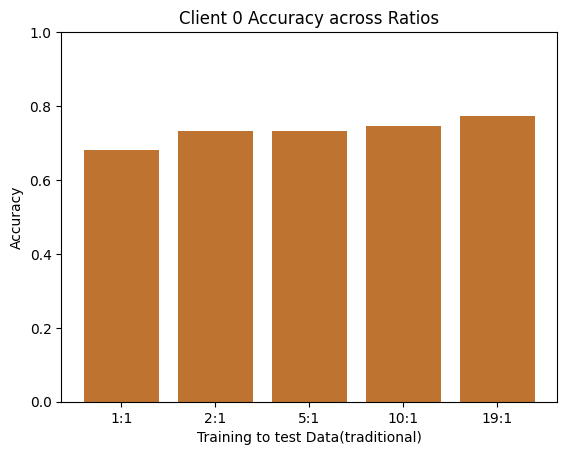

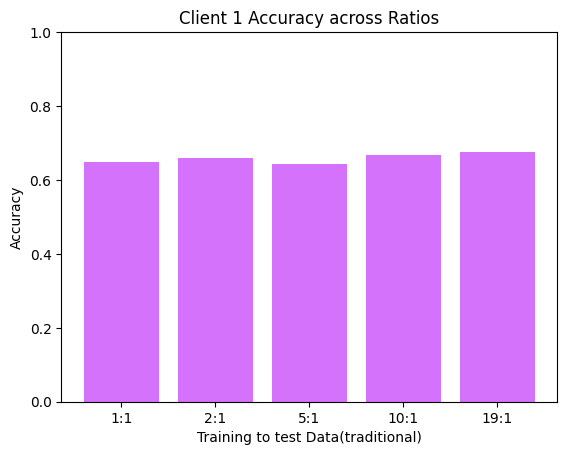

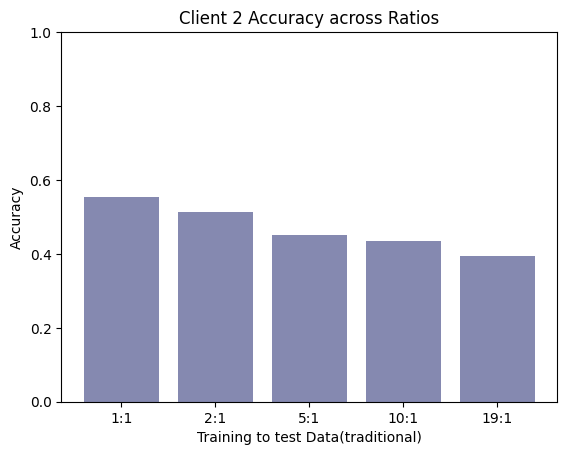

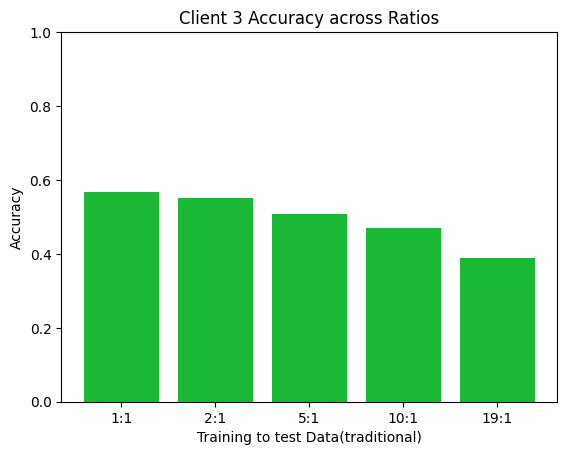

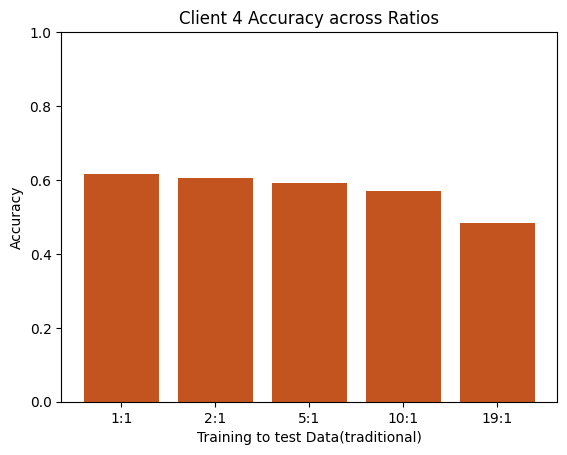

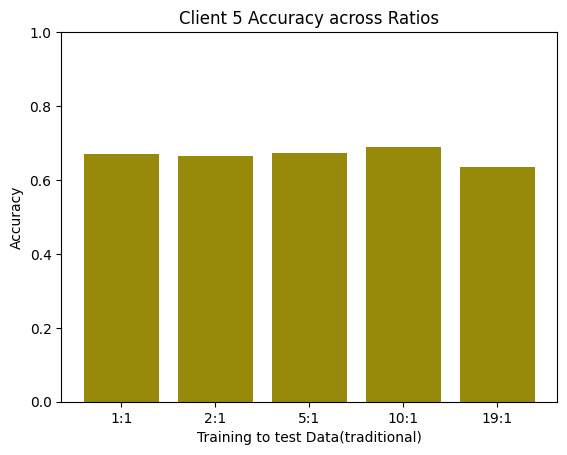

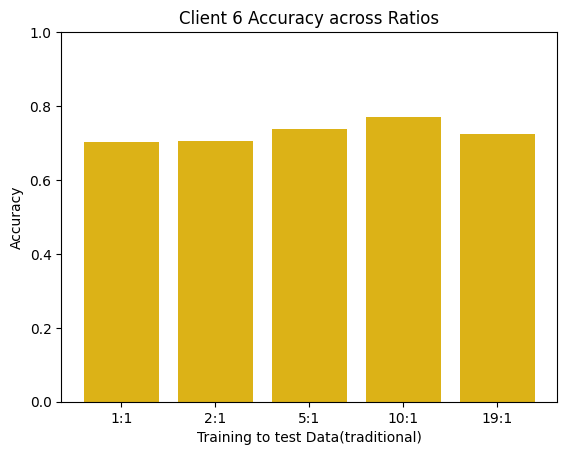

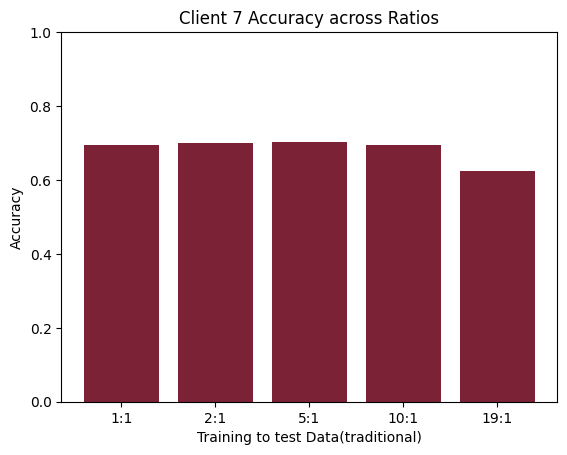

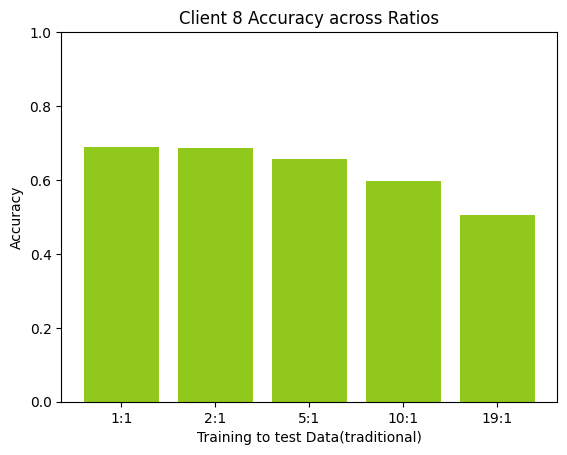

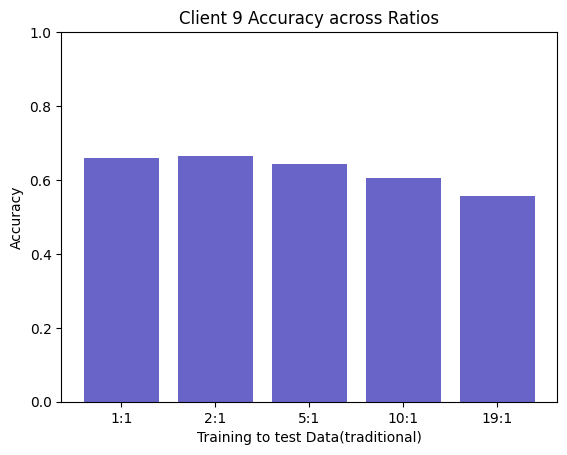

In [ ]:
client_accuracy_data = {
    '1:1': [0.6820,0.6490,0.5530,0.5680,0.6150,0.6710,0.7030,0.6940,0.6880,0.6590],
    '2:1': [0.7320,0.6590,0.5120,0.5510,0.6060,0.6660,0.7060,0.7010,0.6870,0.6650],
    '5:1': [0.7330,0.6440,0.4520,0.5070,0.5910,0.6740,0.7370,0.7030,0.6580,0.6430],
    '10:1': [0.7450,0.6670,0.4360,0.4690,0.5710,0.6900,0.7710,0.6940,0.5980,0.6040],
    '19:1': [0.7720,0.6750,0.3930,0.3880,0.4830,0.6360,0.7240,0.6230,0.5060,0.5560],
}

ratios = list(client_accuracy_data.keys())

for i in range(10):
    accuracies = [client_accuracy_data[ratio][i] for ratio in ratios]
    plt.figure(i)
    plt.bar(ratios, accuracies, color=np.random.rand(3,))
    plt.xlabel('Training to test Data(traditional)')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title(f'Client {i} Accuracy across Ratios')
    plt.show()

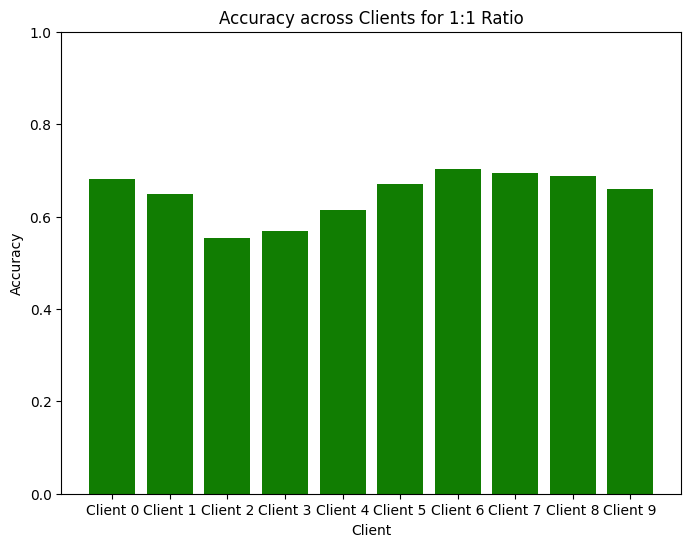

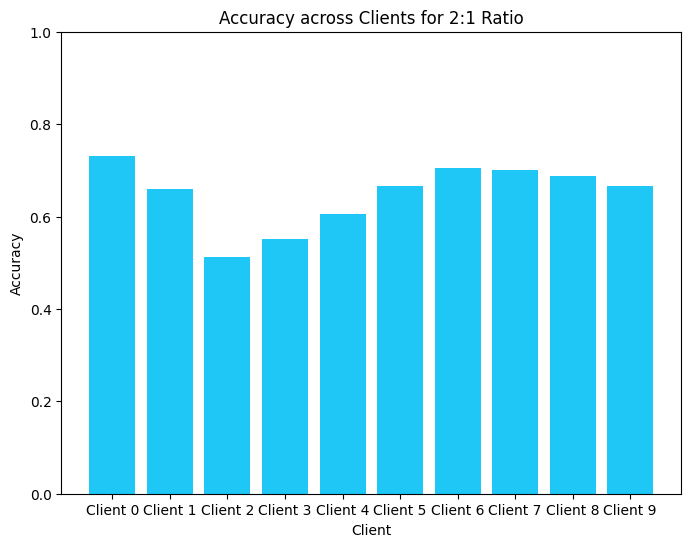

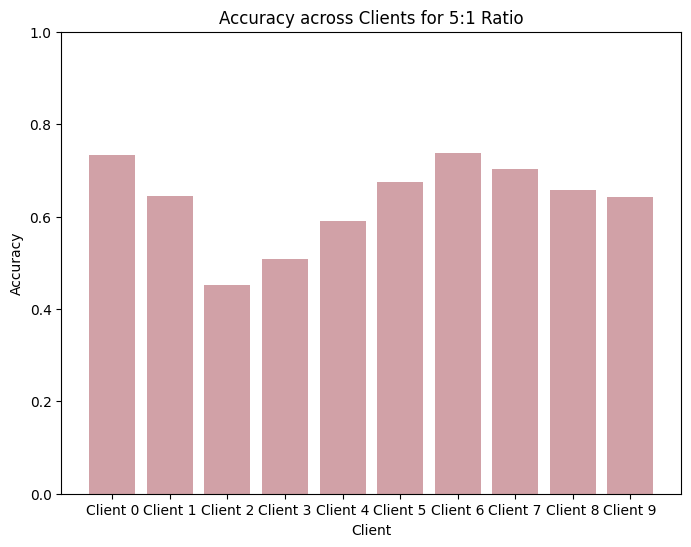

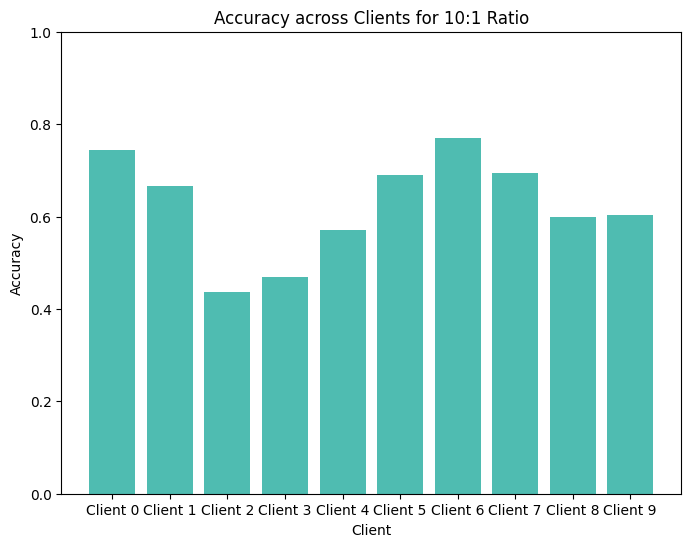

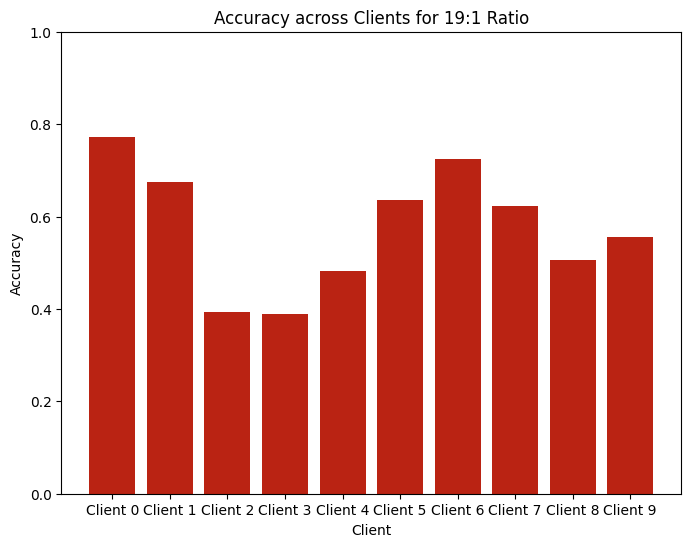

In [ ]:
client_accuracy_data = {
    '1:1': [0.6820, 0.6490, 0.5530, 0.5680, 0.6150, 0.6710, 0.7030, 0.6940, 0.6880, 0.6590],
    '2:1': [0.7320, 0.6590, 0.5120, 0.5510, 0.6060, 0.6660, 0.7060, 0.7010, 0.6870, 0.6650],
    '5:1': [0.7330, 0.6440, 0.4520, 0.5070, 0.5910, 0.6740, 0.7370, 0.7030, 0.6580, 0.6430],
    '10:1': [0.7450, 0.6670, 0.4360, 0.4690, 0.5710, 0.6900, 0.7710, 0.6940, 0.5980, 0.6040],
    '19:1': [0.7720, 0.6750, 0.3930, 0.3880, 0.4830, 0.6360, 0.7240, 0.6230, 0.5060, 0.5560],
}

for ratio in client_accuracy_data.keys():
    accuracies = client_accuracy_data[ratio]
    clients = [f'Client {i}' for i in range(10)]
    plt.figure(figsize=(8, 6))
    plt.bar(clients, accuracies, color=np.random.rand(3,))
    plt.xlabel('Client')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title(f'Accuracy across Clients for {ratio} Ratio')
    plt.show()

In [ ]:
#トレインデータ全体を合わせて1つのモデルにしたモデル
# すべてのクライアントのトレインデータ結合
combined_train_data = []
combined_train_labels = []

for client_name in client_names:
    client_train_data, client_train_labels = zip(*client_data[client_name])
    combined_train_data.extend(client_train_data)
    combined_train_labels.extend(client_train_labels)

combined_train_data = np.array(combined_train_data)
combined_train_labels = np.array(combined_train_labels)

# 統合されたデータセットでモデルトレーニング
combined_model = MLP().build()
combined_model.compile(loss=loss, optimizer=new_optimizer, metrics=metrics)
combined_model.fit(combined_train_data, combined_train_labels, epochs=20, verbose=0)

# 統合モデルを使用して各クライアントのテストデータ評価
combined_results = evaluate_model_on_clients(combined_model, client_test_data, client_names)

# 統合モデルの評価結果出力
print("Results for the combined model:")
sorted_client_names = sorted(client_names)
for client, results in combined_results.items():
    print(f"  Test on {client} - Accuracy: {results['accuracy']:.4f}, Loss: {results['loss']:.4f}")

K.clear_session()



Results for the combined model:
  Test on client_0 - Accuracy: 0.8230, Loss: 0.7165
  Test on client_1 - Accuracy: 0.7270, Loss: 1.0798
  Test on client_2 - Accuracy: 0.5250, Loss: 1.7941
  Test on client_3 - Accuracy: 0.5990, Loss: 1.5059
  Test on client_4 - Accuracy: 0.7050, Loss: 1.0953
  Test on client_5 - Accuracy: 0.7730, Loss: 0.8236
  Test on client_6 - Accuracy: 0.8230, Loss: 0.7134
  Test on client_7 - Accuracy: 0.8350, Loss: 0.6794
  Test on client_8 - Accuracy: 0.7990, Loss: 0.8614
  Test on client_9 - Accuracy: 0.7420, Loss: 1.0907


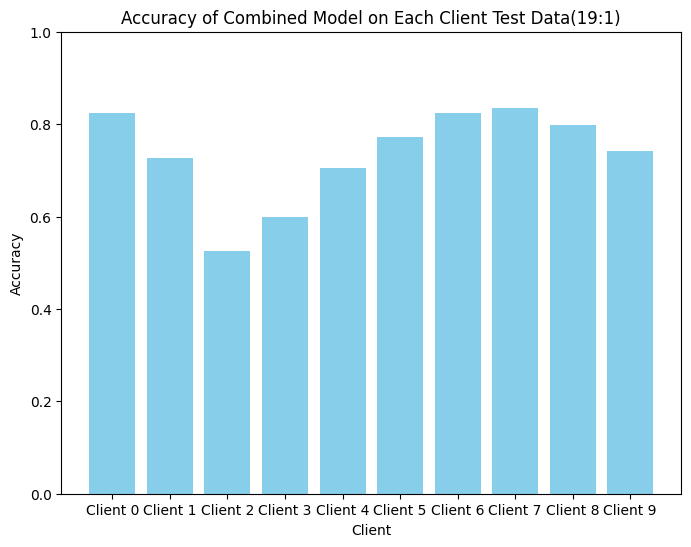

In [7]:
# [0.7720, 0.6750, 0.3930, 0.3880, 0.4830, 0.6360, 0.7240, 0.6230, 0.5060, 0.5560]
combined_results = {
    "client_0": {'accuracy': 0.8230},
    "client_1": {'accuracy': 0.7270},
    "client_2": {'accuracy': 0.5250},
    "client_3": {'accuracy': 0.5990},
    "client_4": {'accuracy': 0.7050},
    "client_5": {'accuracy': 0.7730},
    "client_6": {'accuracy': 0.8230},
    "client_7": {'accuracy': 0.8350},
    "client_8": {'accuracy': 0.7990},
    "client_9": {'accuracy': 0.7420}
}

accuracies = [combined_results[f'client_{i}']['accuracy'] for i in range(10)]

clients = [f'Client {i}' for i in range(10)]

plt.figure(figsize=(8, 6))
plt.bar(clients, accuracies, color='skyblue')
plt.xlabel('Client')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracy of Combined Model on Each Client Test Data(19:1)')
plt.show()